In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re

Here is what the text file looks like. The Information appears to be set up as a dictionary with the categories: ID, ASIN, title, group, salesrank, similar, categories (this looks like it has sub-elements), reviews (again with sub-elements). Actually, it reminds me a bit of an XML file in that way.

Id: 1 ASIN: 0827229534 title: Patterns of Preaching: A Sermon Sampler group: Book salesrank: 396585 similar: 5 0804215715 156101074X 0687023955 0687074231 082721619X categories: 2 |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368] |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370] reviews: total: 2 downloaded: 2 avg rating: 5 2000-7-28 cutomer: A2JW67OY8U6HHK rating: 5 votes: 10 helpful: 9 2003-12-14 cutomer: A2VE83MZF98ITY rating: 5 votes: 6 helpful: 5

Id: 2 ASIN: 0738700797 title: Candlemas: Feast of Flames group: Book salesrank: 168596 similar: 5 0738700827 1567184960 1567182836 0738700525 0738700940 categories: 2 |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484] |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Witchcraft[12486] reviews: total: 12 downloaded: 12 avg rating: 4.5 2001-12-16 cutomer: A11NCO6YTE4BTJ rating: 5 votes: 5 helpful: 4 2002-1-7 cutomer: A9CQ3PLRNIR83 rating: 4 votes: 5 helpful: 5 2002-1-24 cutomer: A13SG9ACZ9O5IM rating: 5 votes: 8 helpful: 8 2002-1-28 cutomer: A1BDAI6VEYMAZA rating: 5 votes: 4 helpful: 4 2002-2-6 cutomer: A2P6KAWXJ16234 rating: 4 votes: 16 helpful: 16 2002-2-14 cutomer: AMACWC3M7PQFR rating: 4 votes: 5 helpful: 5 2002-3-23 cutomer: A3GO7UV9XX14D8 rating: 4 votes: 6 helpful: 6 2002-5-23 cutomer: A1GIL64QK68WKL rating: 5 votes: 8 helpful: 8 2003-2-25 cutomer: AEOBOF2ONQJWV rating: 5 votes: 8 helpful: 5 2003-11-25 cutomer: A3IGHTES8ME05L rating: 5 votes: 5 helpful: 5 2004-2-11 cutomer: A1CP26N8RHYVVO rating: 1 votes: 13 helpful: 9 2005-2-7 cutomer: ANEIANH0WAT9D rating: 5 votes: 1 helpful: 1

Id: 3 ASIN: 0486287785 title: World War II Allied Fighter Planes Trading Cards group: Book salesrank: 1270652 similar: 0 categories: 1 |Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144] reviews: total: 1 downloaded: 1 avg rating: 5 2003-7-10 cutomer: A3IDGASRQAW8B2 rating: 5 votes: 2 helpful: 2

Id: 4 ASIN: 0842328327 title: Life Application Bible Commentary: 1 and 2 Timothy and Titus group: Book salesrank: 631289 similar: 5 0842328130 0830818138 0842330313 0842328610 0842328572 categories: 5 |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Reference[172810]|Commentaries[12155]|New Testament[12159] |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Christian Living[12333]|Discipleship[12335] |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Translations[764432]|Life Application[572080] |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Bible & Other Sacred Texts[12056]|Bible[764430]|New Testament[572082] |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Study Guides, History & Reference[764438]|General[572094] reviews: total: 1 downloaded: 1 avg rating: 4 2004-8-19 cutomer: A2591BUPXCS705 rating: 4 votes: 1 helpful: 1

Ultimately I only need to access the information in the ratings section and the category section. The issue is that both of these are complex sections. The ratings has customer information in it that may actually be useful as a cursory glance shows that some custormers are posting multiple times on the same product - thus skewing the ratings. Further, it has votes and helpfulness aspects and dates.

The category section is a mess of multiple labels. I'm guessing these are trees in a sense and only the last label matters, but I'm not sure.
#### These are the tasks I need to do:

1. Trustworthiness of ratings Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively speaking) about the ratings in this dataset?

So, from the ratings I should make sure to select the customer id (to check for people who are posting multiple reviews on teh same product), the rating, the votes, and the helpful marks. I can look for correations between what rating is given and how helpful it was, recalcualted averages without duplicates, etc. I will also get the line saying what the average rating and total number of ratings is.

2 Category bloat

Consider the product group named 'Books'. Each product in this group is associated with categories. Naturally, with categorization, there are tradeoffs between how broad or specific the categories must be. For this dataset, quantify the following: a. Is there redundancy in the categorization? How can it be identified/removed? b. Is is possible to reduce the number of categories drastically (say to 10% of existing categories) by sacrificing relatively few category entries (say close to 10%)?

I will need to check which category the product is and only keep the books, then make a record of different categories so I can check counts of categories to look for redundencies

## Part 1

In [62]:
reviews = pd.read_pickle('first_method_all.pkl')
reviews.head()

CID rating votes helpful
0001054600 0  A3EBTGZWHEF0S6      5     0       0
           1  A1RDPX33VRWNRS      4     0       0
           2   ATVPDKIKX0DER      5     0       0
           3  A2INDL2WDASVRX      5     0       0
           4   ATVPDKIKX0DER      5     0       0

In [63]:
reviews['CID'].value_counts()

ATVPDKIKX0DER     406351
A3UN6WX5RRO2AG     82856
A14OJS0VWMOSWO      4106
A2NJO6YE954DBH      2707
AFVQZQ8PW0L         2356
A9Q28YTLYREO7       1918
A1K1JW1C5CUSUZ      1568
AU8552YCOO5QX       1257
A3LZGLA88K0LA0       980
A20EEWWSFMZ1PN       966
A1D2C0WDCSHUWZ       908
A1GN8UJIZLCA59       880
A2ODBHT4URXVXQ       853
A3P1A63Q8L32C5       840
A3QZCA4LTTVGAD       803
A3KF4IP2MUS8QQ       792
A3QVAKVRAH657N       782
A16CZRQL23NOIW       750
A96K1ZGW56S2I        712
A2EENLV6OQ3DYM       711
A31U2QT7SAL7K        698
AJKWF4W7QD4NS        698
A1IU7S4HCK1XK0       696
A2QRB6L1MCJ53G       692
A26JGAM6GZMM4V       686
A1NATT3PN24QWY       681
A281NPSIMI1C2R       662
A26TSW6AI59ZCV       622
A1IOJE0W1NXOSE       621
A37F1G84K35FCZ       620
                   ...  
A1WKUANC0T3F3Y         1
A33XN8E1ZCDFCK         1
A2R0S5N9E33WMG         1
A2EDEU1LWJTGC7         1
A76WZDOZ6NV2O          1
ADU3NOCDQSR7J          1
A30YYKA342Z0NF         1
A3T8K6GYBSLODY         1
A3HYMBYEV60HAG         1


(array([  5.62515000e+05,   2.72185000e+05,   6.55060000e+04,
          2.61650000e+04,   1.35520000e+04,   7.92200000e+03,
          5.38400000e+03,   3.68100000e+03,   2.64500000e+03,
          2.11700000e+03,   1.58700000e+03,   1.29100000e+03,
          1.08900000e+03,   8.99000000e+02,   7.64000000e+02,
          6.50000000e+02,   5.60000000e+02,   4.55000000e+02,
          4.43000000e+02,   3.87000000e+02,   3.51000000e+02,
          3.17000000e+02,   2.84000000e+02,   2.43000000e+02,
          2.43000000e+02,   2.05000000e+02,   1.93000000e+02,
          1.83000000e+02,   1.62000000e+02,   1.49000000e+02,
          1.40000000e+02,   1.24000000e+02,   1.26000000e+02,
          1.02000000e+02,   1.20000000e+02,   9.80000000e+01,
          1.10000000e+02,   7.40000000e+01,   6.70000000e+01,
          8.20000000e+01,   7.90000000e+01,   5.00000000e+01,
          6.00000000e+01,   6.70000000e+01,   6.70000000e+01,
          5.40000000e+01,   4.70000000e+01,   4.70000000e+01,
        

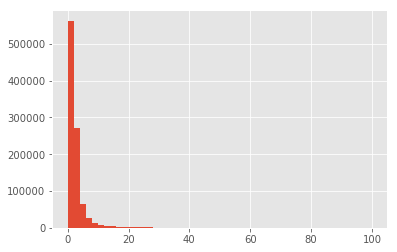

In [68]:
plt.hist(reviews['CID'].value_counts(), bins = 50, range=[0,100])

There are a few extreme outliers on the number of ratings. Most only rate a couple of times. As you can see below.

In [69]:
reviews['CID'].value_counts().value_counts()

1       562515
2       187897
3        84288
4        42779
5        22727
6        16083
7        10082
8         7871
9         5681
10        4488
11        3434
12        3062
13        2322
14        2011
15        1670
16        1403
17        1242
18        1140
19         977
20         836
21         751
22         671
23         620
24         599
25         490
26         456
27         443
28         387
29         377
30         326
         ...  
334          1
585          1
339          1
853          1
342          1
346          1
577          1
349          1
574          1
351          1
361          1
328          1
327          1
596          1
304          1
617          1
297          1
616          1
298          1
614          1
303          1
611          1
324          1
307          1
2356         1
312          1
314          1
319          1
320          1
510          1
Name: CID, Length: 440, dtype: int64

In [71]:
most = reviews[reviews['CID'] == 'ATVPDKIKX0DER']
most['rating'].value_counts()

5    281458
4     57537
1     27507
3     23584
2     16265
Name: rating, dtype: int64

(array([  251671.,        0.,   179338.,        0.,        0.,   271474.,
               0.,   605602.,        0.,  1963811.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

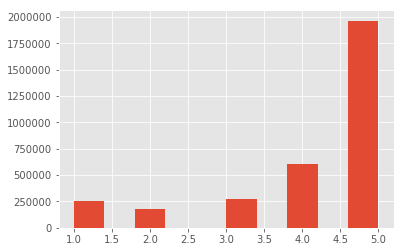

In [72]:
plt.hist(reviews['rating'])

In [74]:
rate = reviews['rating'].value_counts()
rate

5    1963811
4     605602
3     271474
1     251671
2     179338
Name: rating, dtype: int64

Both visually and quantitatively you can see here that the ratings are greatly skewed to the high end.

In [77]:
sum(reviews['helpful'])/sum(reviews['votes'])

0.6477449566238744

In [94]:
np.mean(reviews['rating'])

4.1768540320352479

### Part 1 Answer

The vast majority of ratings are 5's (about 60%) and the average rating is 4.18. There is also an issue of some users voting multiple times on the same product. One user alone did 400,000+ ratings! 

It is also interesting to note that there is a about 65% chance a review will be rated as helpful and only 35%  chance it will be voted as unhelpful. In other words, if someone takes the time to vote on a review, usuallly it is because they like it.

## Part 2

In [3]:
# Define read_large_file()
def read_large_file(file_object):
    """A generator function to read a large file lazily."""

    # Loop indefinitely until the end of the file
    while True:

        # Read a line from the file: data
        data = file_object.readline()

        # Break if this is the end of the file
        if not data:
            break

        # Yield the line of data
        yield data

In [4]:
with open('subset.txt', encoding = 'latin-1') as file:

    # Iterate over the generator from read_large_file()
    for line in read_large_file(file):  
        if len(line) >= 3:
            if line[3] == '|':
                customer_info = line.split('|')
                category = customer_info[-1][:-2]

In [5]:
customer_info

['   ',
 'Music[5174]',
 'Specialty Stores[468040]',
 'Imports[701208]',
 'Jazz[916554]\n']

In [8]:
category = customer_info[-1][:-1]

In [9]:
category

'Jazz[916554]'

### Do not run this next cell again, just load 'category.pkl'.

In [14]:
# Here I will again get the ASIN and then collect the category of all the books. 

category_df = pd.DataFrame(columns=['product', 'category']) 
full_cat_df = pd.DataFrame(columns=['product', 'category']) 
cat = 'something'# prepare category check

with open('amazon-meta.txt', encoding = 'latin-1') as file:

    # Iterate over the generator from read_large_file()
    for line in read_large_file(file):  
        row = line.split(':')                    # read the line
        first_col = row[0]                       # select the asin
        if first_col[0] == 'A':
            ID = row[1]
            ID = re.findall(r'\w+', ID)
            
        if len(first_col) >= 3:
            if first_col[2] == 'g' and row[1][1] == 'B':
                cat = 'book'
            elif first_col[2] =='g' and row[1][1] !='B':
                cat = 'something'
        if len(line) >= 3:
            if line[3] == '|' and cat == 'book':
                fullcat = line[:-1]
                customer_info = line.split('|')
                category = customer_info[-1][:-1] # forgot to change this before I ran it, but a future running would make it look like I want
                category_df = category_df.append({'product': ID, 'category': category}, ignore_index = True)
                full_cat_df = full_cat_df.append({'product': ID, 'category': fullcat}, ignore_index = True)
            

KeyboardInterrupt: 

In [15]:
len(category_df)

363302

In [16]:
category_df.head()

,product,category
0,[0827229534],Preaching[12368
1,[0827229534],Sermons[12370
2,[0738700797],Wicca[12484
3,[0738700797],Witchcraft[12486
4,[0486287785],General[5144


In [17]:
len(full_cat_df)

363302

In [18]:
full_cat_df.head(10)

,product,category
0,[0827229534],|Books[283155]|Subjects[1000]|Religion & Sp...
1,[0827229534],|Books[283155]|Subjects[1000]|Religion & Sp...
2,[0738700797],|Books[283155]|Subjects[1000]|Religion & Sp...
3,[0738700797],|Books[283155]|Subjects[1000]|Religion & Sp...
4,[0486287785],|Books[283155]|Subjects[1000]|Home & Garden...
5,[0842328327],|Books[283155]|Subjects[1000]|Religion & Sp...
6,[0842328327],|Books[283155]|Subjects[1000]|Religion & Sp...
7,[0842328327],|Books[283155]|Subjects[1000]|Religion & Sp...
8,[0842328327],|Books[283155]|Subjects[1000]|Religion & Sp...
9,[0842328327],|Books[283155]|Subjects[1000]|Religion & Sp...


In [19]:
len(category_df['category'].value_counts())

10968

In [20]:
len(full_cat_df['category'].value_counts())

10968

So far I have looked at the format of the category data and have made two dataframes in slightly different versions - one with the whole category tree and one with just the final category name. As you can see, they have the same length when doing value_counts, so it looks like each ending has a unique tree. With that in mind, I will focus my work on the shorter version. I will also now save these dataframes so I don't have to run the code again.

In [22]:
#category_df.to_pickle('category.pkl')
#full_cat_df.to_pickle('full_cat.pkl')

In [31]:
#category_df['product']=category_df['product'].astype('str') - not the most elegant solution, but it gets the job done

(array([  9.43900000e+03,   7.12000000e+02,   3.27000000e+02,
          1.88000000e+02,   7.90000000e+01,   4.20000000e+01,
          3.70000000e+01,   2.60000000e+01,   1.90000000e+01,
          1.20000000e+01,   1.40000000e+01,   9.00000000e+00,
          8.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   7.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
        

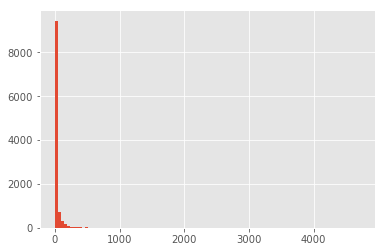

In [24]:
plt.hist(category_df['category'].value_counts(), bins=100)

In [25]:
category_df['category'].value_counts()

General[767880                       4705
General[2612                         4705
General[408268                       3528
General[2375                         3046
General[11289                        2970
General[170062                       2903
Contemporary[10129                   2788
General[10635                        2252
General[657762                       2166
General[170063                       2046
General[11175                        2040
General[11083                        1968
General[11086921                     1744
General[605116                       1685
General[4233                         1610
Classics[10127                       1413
Literary[10132                       1410
General[4738                         1388
General[11043                        1372
General[658010                       1309
General[5144                         1309
General[12341                        1302
General[10466                        1225
General[16282                     

In [33]:
len(category_df['product'].value_counts())

94729

In [34]:
363302/94729

3.83517191145267

So there are an average of 4 categories per product.

In [35]:
category_df.describe()

,product,category
count,363302,363302
unique,94729,10968
top,['9626341408'],General[767880
freq,116,4705


Wow, one product has 116 categories, that's ridiculous.

In [37]:
#just want to see how many books there are since this runs faster than creating the dataframe
#see how many I got since I had to cut it out early
book_count = 0
with open('amazon-meta.txt', encoding = 'latin-1') as file:

    # Iterate over the generator from read_large_file()
    for line in read_large_file(file):  
        row = line.split(':')                    # read the line
        first_col = row[0]  
        if len(first_col) >= 3:
            if first_col[2] == 'g' and row[1][1] == 'B':
                book_count = book_count + 1

print(book_count)

393562


So, I got about 1/4 of the books. I'll have to consider that this 1/4 is representative of the rest of the sample.

In [42]:
x = category_df['category'].value_counts()

In [48]:
x[0:1001].sum()

241377

In [51]:
l = 1000
for i in range(20):
    if x[:l].sum() >= 363302*.85:
        print(l)
        break
    else:
        l = l+100
    

2500


In [52]:
x[:2500].sum()

309175

In [59]:
x[:2500].sum()/len(category_df)*100

85.10137571496992

In [60]:
2500/len(x)*100

22.793581327498178

In [61]:
x[:1100].sum()/len(category_df)*100

68.51187166599688

## Part 2 answer
It appears that there are several redundencies. Each product has an average of 4 categories, with some having many more (up to 116). Further, a quick glance at the most common categories show that most of the top 10 are different "variations" on the category "General". So, yes, there is room for improvement. 

Can these be reduced at low cost? For the most part, yes. If you strictly use 10% of the categories you can revmove about 2/3 of the entries (68%). To remove closer to 90% of the entries you have to get rid of about 25% of the categories.

## Part 3

1. Algorithm thinking
How would build the product categorization from scratch, using similar/co-purchased
information?
2. Product thinking
Now, put on your 'product thinking' hat.
a. Is it a good idea to show users the categorization hierarchy for items?
b. Is it a good idea to show users similar/co-purchased items?
c. Is it a good idea to show users reviews and ratings for items?
d. For each of the above, why? How will you establish the same?

1.
Assuming there is no category labels or information, then I would use an unsupervised learning algorithm to try and cluster similar products. Probably Knn. After finding the clusters I could search those products names/titles to look for words to label the categories. 

If you are looking for the heirarchal structure, a decision tree could be good so that you can look at the nodes to build the heirarchy.

2 
a.
I don't think the category information is especially necessary to be shown, especially in the current format. It is so messy.

b. I do think the similar purchase information is helpful as it gives an idea of other products to consider if this one isn't quite right.

c. I also personally find reviews very helpful.

d. To justify these I would approach it with A/B testing. Let some customers see ratings, and some not and compare the rate of purchases per page visit between the groups. Similarly for the other questions.